# UK Real Estate : A Price Paid Data Analysis

In [1]:
# Importing Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

%matplotlib inline

## Introduction

- The data is produced by Land Registry © Crown copyright 2017, for more information visit [gov.uk/price-paid-data](https://www.gov.uk/government/statistical-data-sets/price-paid-data-downloads)
- The postcodes comes from [freemaptools.com](https://www.freemaptools.com/download-uk-postcode-lat-lng.htm)
- The Shapefiles (Reconstructed UK postcode boundaries) comes from [opendoorlogistics.com](http://www.opendoorlogistics.com/downloads/)

In [2]:
# Loading the data
col_names = ['id', 'price', 'transfer_date', 'postcode', 'type', 'new', 'duration',
            'paon', 'saon', 'street', 'locality', 'city', 'district', 'county', 'ppd_cat', 'record_status']
pp16 = pd.read_csv("pp-2016.csv", header=None, names=col_names)
pp17 = pd.read_csv("pp-2017.csv", header=None, names=col_names)
pp1617 = pp16.append(pp17, ignore_index=True)

# Data extention with postcode, latitude and longitude
ukpostcodes = pd.read_csv("ukpostcodes.csv", usecols=["postcode", "latitude", "longitude"])
ukpostcodes.columns = ["postcode", "lat", "lon"]

In [3]:
# Function to convert binary column to 0s and 1s
def convert_bin(x, b1, b2):
    # True value
    if x == b1:
        return 1
    #False value
    elif x == b2:
        return 0
    else:
        return np.nan

# Applying the function to the column    
pp1617["new"] = pp1617["new"].apply(convert_bin, args=("Y", "N")) # New = 1 / Old = 0

In [4]:
# converting "transfer_date" colums to datetime type
pp1617["transfer_date"] = pd.to_datetime(pp1617["transfer_date"])

# Creating useful columns
pp1617["year"] = pp1617["transfer_date"].dt.year
pp1617["month"] = pp1617["transfer_date"].dt.month
pp1617["lin_month"] = pp1617["month"]
pp1617.loc[pp1617["year"] == 2017, "lin_month"] = 12 + pp1617.loc[pp1617["year"] == 2017, "month"]

In [5]:
# Map Data : Merging the data
map_pp1617 = pp1617.merge(ukpostcodes, on='postcode')

# Adding a column "area"
map_pp1617["area"] = map_pp1617.postcode.str.extract(r'(\D+)', expand=False)

In [6]:
# -- Quick Exploration Of The Data :
sns.set(style="white", palette="deep", color_codes=True)
palette10a = sns.husl_palette(20)
palette10b = sns.husl_palette(20, h=.55)
pp1617.head(10)

,id,price,transfer_date,postcode,type,new,duration,paon,saon,street,locality,city,district,county,ppd_cat,record_status,year,month,lin_month
0,{3B7E0B8F-7987-EA99-E050-A8C062057E77},338000,2016-08-10,MK44 2EL,D,0,F,LABURNHAM COTTAGE,NaN,KIMBOLTON ROAD,BOLNHURST,BEDFORD,BEDFORD,BEDFORD,A,A,2016,8,8
1,{3B7E0B8F-7988-EA99-E050-A8C062057E77},245000,2016-07-15,LU6 1LU,T,0,F,51,NaN,CLIFTON ROAD,NaN,DUNSTABLE,CENTRAL BEDFORDSHIRE,CENTRAL BEDFORDSHIRE,A,A,2016,7,7
2,{3B7E0B8F-7989-EA99-E050-A8C062057E77},275000,2016-07-26,LU6 1RF,T,0,F,3,NaN,CHURCH GREEN,TOTTERNHOE,DUNSTABLE,CENTRAL BEDFORDSHIRE,CENTRAL BEDFORDSHIRE,A,A,2016,7,7
3,{3B7E0B8F-798A-EA99-E050-A8C062057E77},700000,2016-08-01,LU6 2PA,D,0,F,8,NaN,HOLYWELL ROAD,STUDHAM,DUNSTABLE,CENTRAL BEDFORDSHIRE,CENTRAL BEDFORDSHIRE,A,A,2016,8,8
4,{3B7E0B8F-798B-EA99-E050-A8C062057E77},295000,2016-08-12,NN10 9LH,S,0,F,42,NaN,RUSHDEN ROAD,WYMINGTON,RUSHDEN,BEDFORD,BEDFORD,A,A,2016,8,8
5,{3B7E0B8F-798C-EA99-E050-A8C062057E77},280000,2016-08-05,MK40 2AZ,S,0,F,25,NaN,SPENSER ROAD,NaN,BEDFORD,BEDFORD,BEDFORD,A,A,2016,8,8
6,{3B7E0B8F-798D-EA99-E050-A8C062057E77},510000,2016-07-29,MK43 7DB,D,0,F,2,NaN,THE GREEN,HARROLD,BEDFORD,BEDFORD,BEDFORD,A,A,2016,7,7
7,{3B7E0B8F-798E-EA99-E050-A8C062057E77},325000,2016-07-12,LU2 8QN,T,0,F,6,NaN,SALTDEAN CLOSE,NaN,LUTON,LUTON,LUTON,A,A,2016,7,7
8,{3B7E0B8F-798F-EA99-E050-A8C062057E77},300000,2016-07-13,LU6 3LU,T,0,F,79,NaN,CHURCHILL ROAD,NaN,DUNSTABLE,CENTRAL BEDFORDSHIRE,CENTRAL BEDFORDSHIRE,A,A,2016,7,7
9,{3B7E0B8F-7990-EA99-E050-A8C062057E77},225000,2016-08-19,LU2 7JQ,S,0,F,65,NaN,RICHMOND HILL,NaN,LUTON,LUTON,LUTON,A,A,2016,8,8


## Price
### Distribution (exclude outliers)

The Price distribution is very skewed to the right, we need to exclude the big outliers to plot the price distribution.

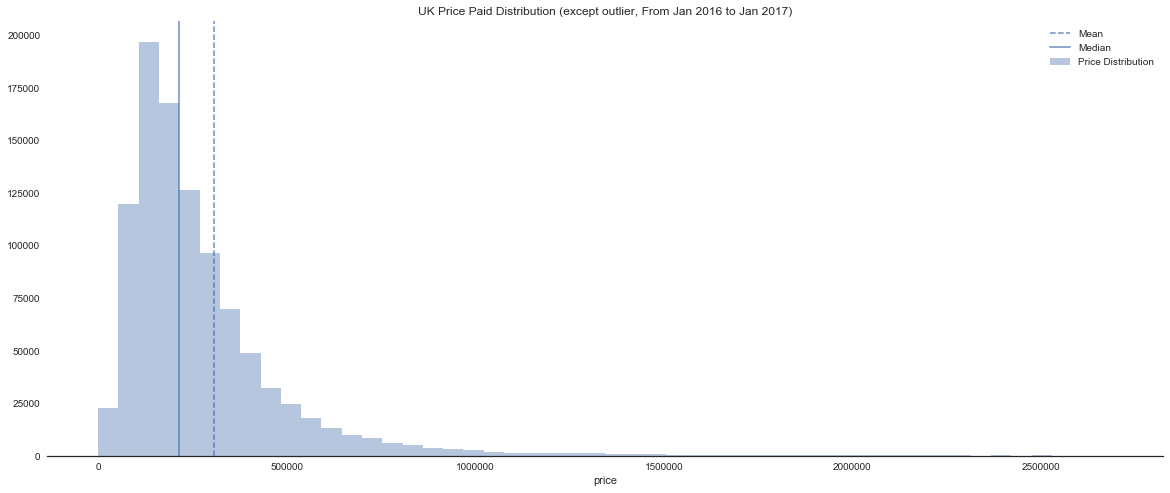

In [7]:
# -- Price Distribution 
# Excluding the outlier
wo_outliers = pp1617.loc[np.abs(pp1617["price"] - pp1617["price"].mean()) <= (3 * pp1617["price"].std())]

# Plotting
fig, ax = plt.subplots(figsize=(20, 8))
ax.set(ylabel="", xlabel="Price (in GBP)", title="UK Price Paid Distribution (except outlier, From Jan 2016 to Jan 2017)")
sns.distplot(wo_outliers["price"], kde=False, color="b", label="Price Distribution")
ax.axvline(pp1617.price.mean(), color='b', linestyle='--', label="Mean", alpha=0.7)
ax.axvline(pp1617.price.median(), color='b', linestyle='-', label="Median", alpha=0.7)
ax.legend(ncol=1, loc="upper right", frameon=False)
sns.despine(left=True)

### Mean and Median

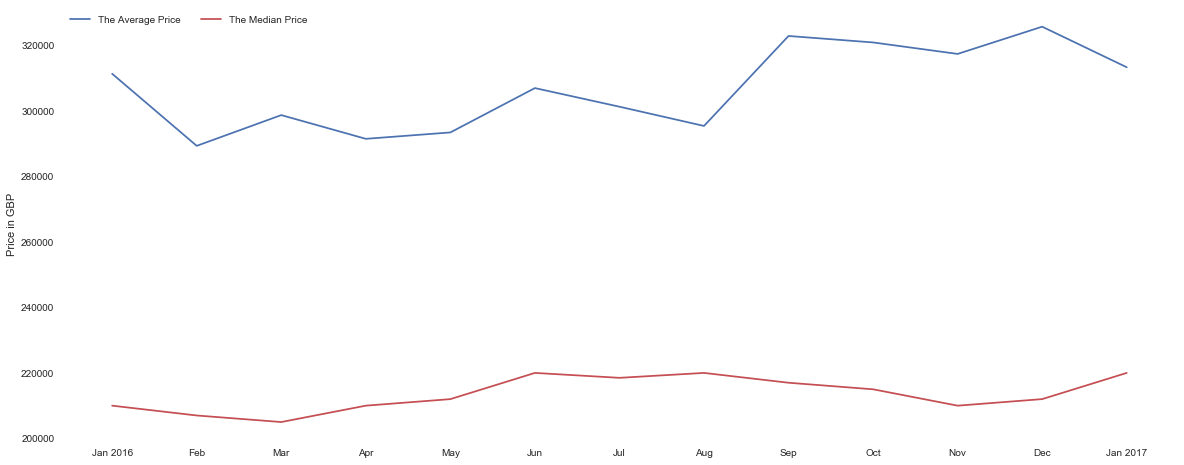

In [8]:
fig, ax1 = plt.subplots(figsize=(20, 8))
price_mean = pp1617.groupby("lin_month").price.mean() 
price_median = pp1617.groupby("lin_month").price.median()
m = ['Jan 2016', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan 2017']
ax1.plot(price_mean, "b-", label="The Average Price")
ax1.plot(price_median, "r-", label="The Median Price")
ax1.set_ylabel('Price in GBP')
ax1.set_xticklabels(m)
plt.xticks(price_mean.index)
ax1.legend(ncol=2, loc="upper left", frameon=False)
sns.despine(left=True, bottom=True)

When the distribution is skewed, the median is the form of 'average' that gives a better idea of any general tendency in the data. So, in this analysis we choose to mostly use the median.

## Categorical Data
### Descriptive Data

[<matplotlib.text.Text at 0x12df54a90>, <matplotlib.text.Text at 0x12df607f0>]

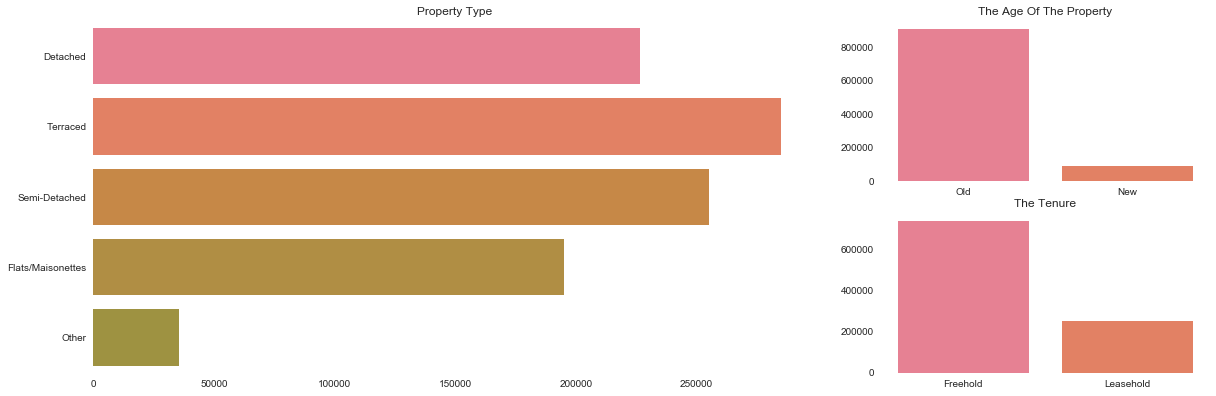

In [9]:
# -- Descriptive Data 
# Plotting the graphs

fig = plt.figure(figsize=(20, 10))

ax1 = plt.subplot2grid((3, 3), (0, 0), rowspan=2, colspan=2) # Type
ax2 = plt.subplot2grid((3, 3), (0, 2)) # New
ax3 = plt.subplot2grid((3, 3), (1, 2)) # Duration

# Type : D = Detached, S = Semi-Detached, T = Terraced, F = Flats/Maisonettes, O = Other 
sns.countplot(y="type", data=pp1617, ax=ax1, palette=palette10a)
sns.despine(left=True, bottom=True)

ax1.set(ylabel="", xlabel="", title="Property Type")
ax1.set_yticklabels(["Detached", "Terraced", "Semi-Detached", "Flats/Maisonettes", "Other"])

# New : 1 = New, 0 = Old 
sns.countplot(x="new", data=pp1617, ax=ax2, palette=palette10a)
sns.despine(left=True, bottom=True)

ax2.set(ylabel="", xlabel="", title="The Age Of The Property")
ax2.set_xticklabels(["Old","New"])

# Duration : F = Freehold, L= Leasehold
sns.countplot(x="duration", data=pp1617, ax=ax3, palette=palette10a)
sns.despine(left=True, bottom=True)

ax3.set(ylabel="", xlabel="", title="The Tenure")
ax3.set_xticklabels(["Freehold","Leasehold"])

In [10]:
# -- Number of newly built
pp1617.loc[pp1617["new"] == 1, "id"].count()

88714

In [11]:
# -- Number of freehold
pp1617.loc[pp1617["duration"] == "F", "id"].count()

742657

In [12]:
# -- The most expensive transaction
pp1617.sort_values("price", ascending=False).iloc[0:3]

,id,price,transfer_date,postcode,type,new,duration,paon,saon,street,locality,city,district,county,ppd_cat,record_status,year,month,lin_month
220227,{3914047A-8399-3206-E050-A8C063057647},96840522,2016-06-15,WC1V 6JS,O,0,F,"THE EYE, 100 - 110",NaN,HIGH HOLBORN,NaN,LONDON,CAMDEN,GREATER LONDON,B,A,2016,6,6
268864,{453D27A3-E10E-EF91-E050-A8C0630574D7},96350000,2016-12-12,NW1 2PN,O,0,F,"THE SOLS ARMS PUBLIC HOUSE, 65",NaN,HAMPSTEAD ROAD,NaN,LONDON,CAMDEN,GREATER LONDON,B,A,2016,12,12
51750,{404A5AF4-689B-CD2B-E050-A8C063055C7B},93597046,2016-05-31,W1K 4DX,O,0,L,19,NaN,BROOKS MEWS,NaN,LONDON,CITY OF WESTMINSTER,GREATER LONDON,B,A,2016,5,5


In [13]:
# -- Number of transactions > 1 000 000 GDP
over = pp1617.loc[pp1617["price"] > 1000000, "id"].count()
total = pp1617["id"].count()
(over/total) * 100

2.1693828640504704

In [14]:
# Number of newly built
pp1617.loc[pp1617["new"] == 1, "id"].count()

88714

#### Fact from the data 

Between January 2016 and January 2017 : 
- 88,714 were newly built 
- 742,657 were freehold
- 21,643 sales for £1 million and over (2 percents of the total transactions)
- The most exensive transaction was in London Borough of Camden in July 2016 for £96,8 million.

### The Median Price 

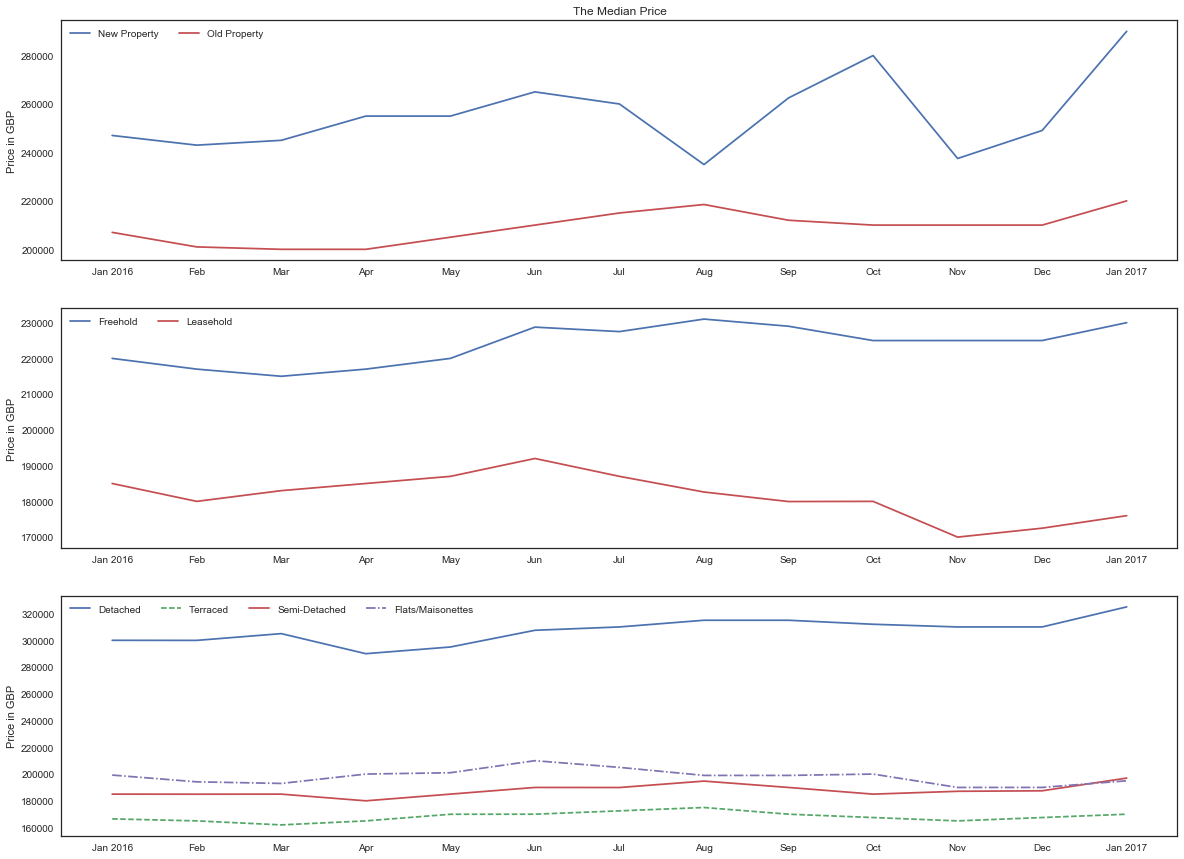

In [15]:
fig = plt.figure(figsize=(20, 15))

# The Median Price by the age of the property
price_median_new = pp1617[pp1617["new"] == 1].groupby("lin_month").price.median()
price_median_old = pp1617[pp1617["new"] == 0].groupby("lin_month").price.median()

ax4 = plt.subplot2grid((3, 3), (0, 0), colspan=3) # The Median Price by Age of Property
plt.xticks(price_median_new.index)

m = ['Jan 2016', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan 2017']
ax4.plot(price_median_new, "b-", label="New Property")
ax4.plot(price_median_old, "r-", label="Old Property")
ax4.set(ylabel="Price in GBP", xlabel="", title="The Median Price")
ax4.set_xticklabels(m)
ax4.legend(ncol=2, loc="upper left", frameon=False)

# The Median Price by Tenure
price_median_f = pp1617[pp1617["duration"] == "F"].groupby("lin_month").price.median()
price_median_l = pp1617[pp1617["duration"] == "L"].groupby("lin_month").price.median()

ax5 = plt.subplot2grid((3, 3), (1, 0), colspan=3) # The Median Price by Tenure
plt.xticks(price_median_f.index)

ax5.plot(price_median_f, "b-", label="Freehold")
ax5.plot(price_median_l, "r-", label="Leasehold")
ax5.set(ylabel="Price in GBP", xlabel="", title="")
ax5.set_xticklabels(m)
ax5.legend(ncol=2, loc="upper left", frameon=False)

# The Median Price by Type
price_median_d = pp1617[pp1617["type"] == "D"].groupby("lin_month").price.median()
price_median_t = pp1617[pp1617["type"] == "T"].groupby("lin_month").price.median()
price_median_sd = pp1617[pp1617["type"] == "S"].groupby("lin_month").price.median()
price_median_fm = pp1617[pp1617["type"] == "F"].groupby("lin_month").price.median()

ax6 = plt.subplot2grid((3, 3), (2, 0), colspan=3) # The Median Price by Type
plt.xticks(price_median_d.index)

ax6.plot(price_median_d, "b-", label="Detached")
ax6.plot(price_median_t, "g--", label="Terraced")
ax6.plot(price_median_sd, "r-", label="Semi-Detached")
ax6.plot(price_median_fm, "m-.", label="Flats/Maisonettes")

ax6.set(ylabel="Price in GBP", xlabel="", title="")
ax6.set_xticklabels(m)
ax6.legend(ncol=5, loc="upper left", frameon=False)

The median price is higher for new properties than for the old ones. Note the price of the old and the new properties that seems to converge between June and August. We'll respond to this in the next section.

As we might think, leasehold properties are cheaper than freehold properties and the detached properties are much more expensive than the other types.

## Monthly Analysis

In [16]:
df = pp1617[(pp1617["lin_month"] == 1) | (pp1617["lin_month"] == 13)]

[<matplotlib.text.Text at 0x12d6a5e80>, <matplotlib.text.Text at 0x12d698f28>]

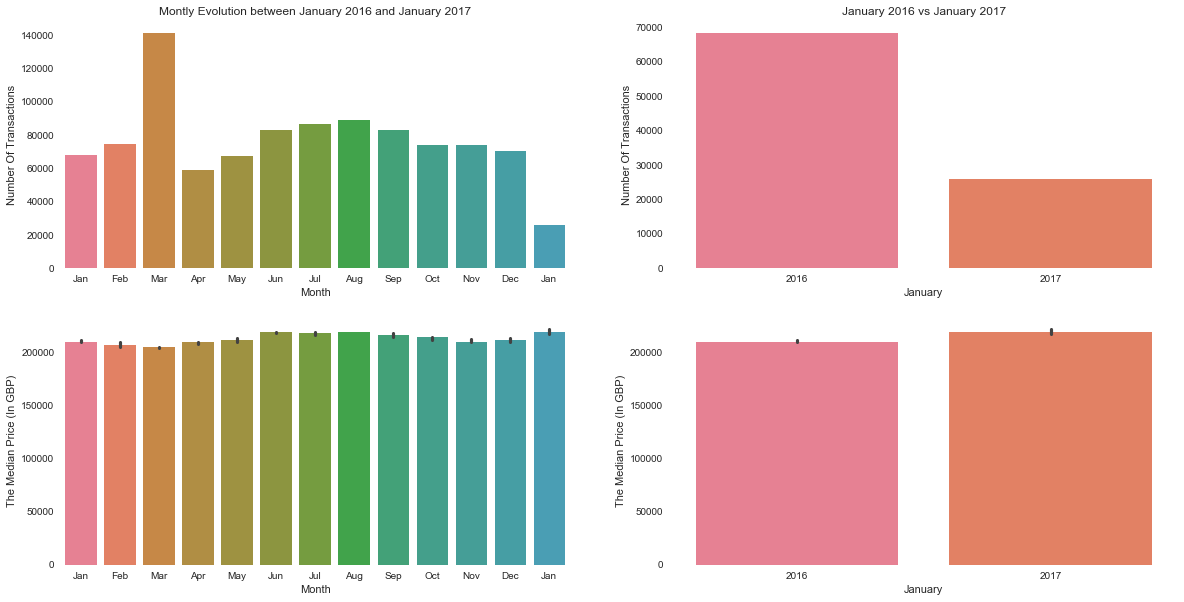

In [17]:
fig, ((ax1, ax2) , (ax3, ax4)) = plt.subplots(2, 2, figsize=(20,10))

p = sns.countplot(x=pp1617["lin_month"], ax=ax1, palette=palette10a)
z = sns.countplot(x=df["lin_month"], ax=ax2, palette=palette10a)
v = sns.barplot(y=pp1617["price"], x=pp1617["lin_month"], estimator=np.median, ax=ax3, palette=palette10a)
q = sns.barplot(y=df["price"], x=df["lin_month"], estimator=np.median, ax=ax4, palette=palette10a)

m = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan']
y = ["2016","2017"]
# Add a legend and informative axis label
p.set_xticklabels(m)
z.set_xticklabels(y)
v.set_xticklabels(m)
q.set_xticklabels(y)
sns.despine(left=True, bottom=True)
ax1.set(ylabel="Number Of Transactions", xlabel="Month", title="Montly Evolution between January 2016 and January 2017")
ax2.set(ylabel="Number Of Transactions", xlabel="January", title="January 2016 vs January 2017")
ax3.set(ylabel="The Median Price (In GBP)", xlabel="Month")
ax4.set(ylabel="The Median Price (In GBP)", xlabel="January")

In [18]:
# -- % of volume variation 
VA = df.loc[df["lin_month"] == 13, "id"].count()
VD = df.loc[df["lin_month"] == 1, "id"].count()
VAR  = (VA - VD) / VD
VAR * 100

-62.127310782921796

If we compare January 2016 and January 2017, the volume of transactions drops by 62 percent, meanwhile the median price increase a little bit. We can also note the peak of transaction volume that occurred in March 2016. After a little investigation (see [which.co.uk/buy-to-let-stamp-duty](http://www.which.co.uk/money/mortgages-and-property/home-movers/guides/stamp-duty/buy-to-let-stamp-duty) or [telegraph.co.uk/buy-to-let-stamp-duty-will-you-have-to-pay/](http://www.telegraph.co.uk/investing/buy-to-let/buy-to-let-stamp-duty-will-you-have-to-pay/)), we discover that from April 2016 landlords now have to pay an extra 3% stamp duty on property purchases, so some buyers were incitate to close the deal before April, that explain the higher volume in March 2016.

The fact that investors brought forward purchases to avoid new stamp duty rates partly explain the fall we see earlier in newly built (between June and August), the other part of the explanation comes from the Brexit vote in June 2016, buyers and sellers have prefered to wait before entering the market. The low volume of transaction in January 2017, seems to come from the same causes.

## Counties And Cities Analysis
### Top 10 Counties and Top 10 Cities

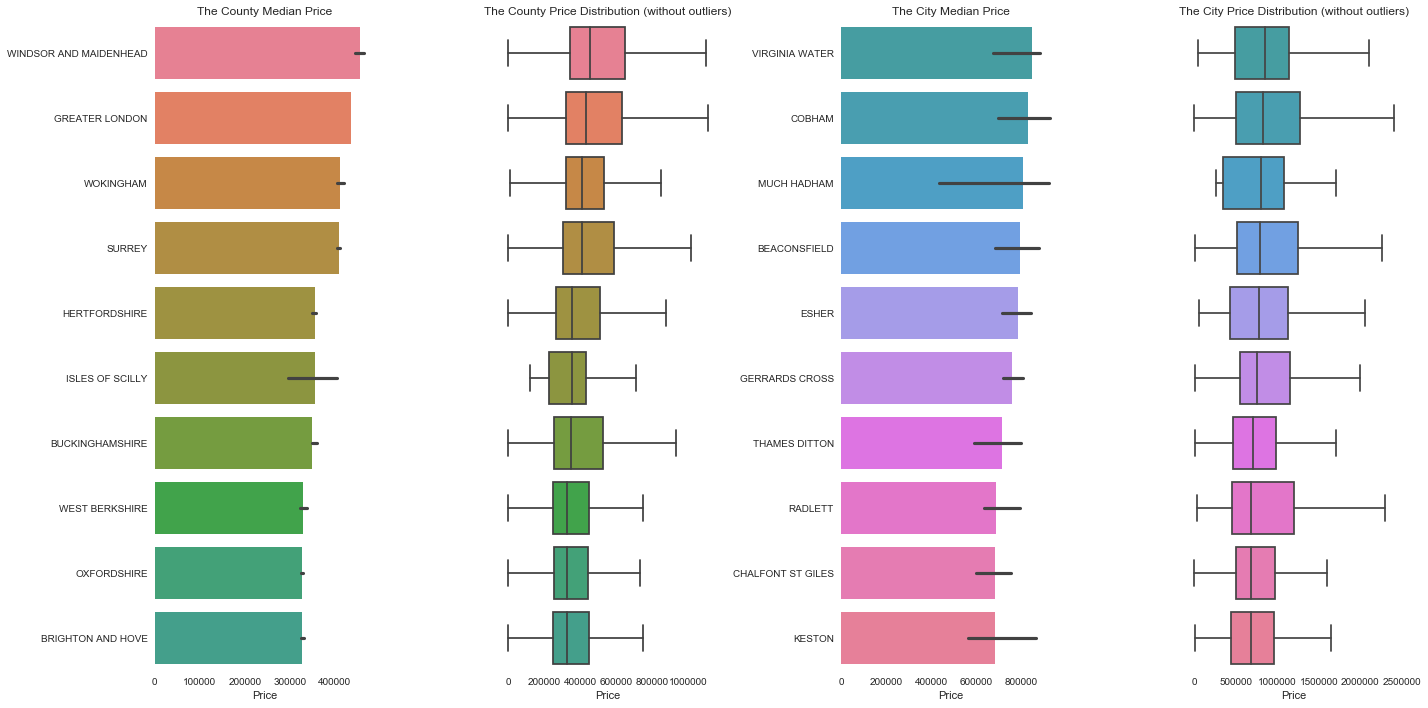

In [19]:
fig, axes = plt.subplots(1, 4, figsize=(20, 10))
# Data
my_order = pp1617.groupby("county").median().sort_values("price", ascending=False).iloc[0:10].index
my_order2 = pp1617.groupby("city").median().sort_values("price", ascending=False).iloc[0:10].index

# Plots
c1 = sns.barplot(y="county", x="price", data=pp1617, order=my_order, palette=palette10a, estimator=np.median, ax=axes[0])
c2 = sns.boxplot(y="county", x="price", data=pp1617, order=my_order, palette=palette10a, showfliers=False, ax=axes[1])
c3 = sns.barplot(y="city", x="price", data=pp1617, order=my_order2, palette=palette10b, estimator=np.median, ax=axes[2])
c4 = sns.boxplot(y="city", x="price", data=pp1617, order=my_order2, palette=palette10b, showfliers=False, ax=axes[3])

# Labels
c1.set_yticklabels(c1.get_yticklabels())
c2.set_yticklabels("")
c3.set_yticklabels(c3.get_yticklabels())
c4.set_yticklabels("")

# Axis
axes[0].set(ylabel="", xlabel="Price", title="The County Median Price")
axes[1].set(ylabel="", xlabel="Price", title="The County Price Distribution (without outliers)")
axes[2].set(ylabel="", xlabel="Price", title="The City Median Price")
axes[3].set(ylabel="", xlabel="Price", title="The City Price Distribution (without outliers)")

sns.despine(left=True, bottom=True)
plt.tight_layout()

In [20]:
# The London median price ranking (base index 0)
pp1617.groupby("city").median().sort_values("price", ascending=False).reset_index().iloc[37:41, 0]

37      WEYBRIDGE
38    CHISLEHURST
39         LONDON
40       SALCOMBE
Name: city, dtype: object

In [21]:
# The London mean price ranking (base index 0)
pp1617.groupby("city").mean().sort_values("price", ascending=False).reset_index().iloc[12:16, 0]

12            NORTHWOOD
13    CHALFONT ST GILES
14               LONDON
15           TWICKENHAM
Name: city, dtype: object

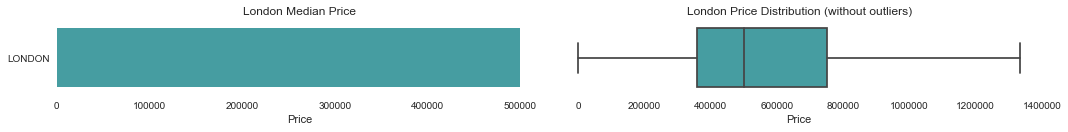

In [22]:
# Constructing the similar plot for London Median and Distribution
london = pp1617[pp1617["city"] == "LONDON"]

fig, axes = plt.subplots(1, 2, figsize=(15, 2))

l1 = sns.barplot(y="city", x="price", data=london, palette=palette10b, estimator=np.median, ax=axes[0])
l2 = sns.boxplot(y="city", x="price", data=london, palette=palette10b, showfliers=False, ax=axes[1])

l1.set_yticklabels(l1.get_yticklabels())
l2.set_yticklabels("")

axes[0].set(ylabel="", xlabel="Price", title="London Median Price")
axes[1].set(ylabel="", xlabel="Price", title="London Price Distribution (without outliers)")

sns.despine(left=True, bottom=True)
plt.tight_layout()

In [23]:
# The number of county in the top 10 cities
ind = pp1617.groupby("city", as_index=False).median().sort_values("price", ascending=False).iloc[0:10].index
pp1617.iloc[ind, 13].value_counts()

SURREY                          3
SOUTH YORKSHIRE                 1
BATH AND NORTH EAST SOMERSET    1
READING                         1
WEST BERKSHIRE                  1
LUTON                           1
KENT                            1
TYNE AND WEAR                   1
Name: county, dtype: int64

We continue our little adventure by comparing the top 10 counties in term of median price. 

First, the top 10 counties seems to be close to London (we will see if that is true in the next section). 

Finaly, I was a little bit suprise to not seen London in the top 10 cities, in fact London is ranked 38th in term of median price (and he is ranked 13th in term of mean price). Note that the county of Surrey has 3 cities in the top 10, beside that, all others cities come from different county.

### Data City Map

In [24]:
# Preparing the data
map_by_median_price = map_pp1617.groupby("area").median()
map_by_median_price["price"] = map_by_median_price["price"].astype("int")
map_by_median_price = map_by_median_price[["price", "lat", "lon"]]
map_by_median_price.index.names = ["area"]
map_by_median_price = map_by_median_price.reset_index()

In [25]:
# Importing basemap
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import Normalize

import matplotlib.cm

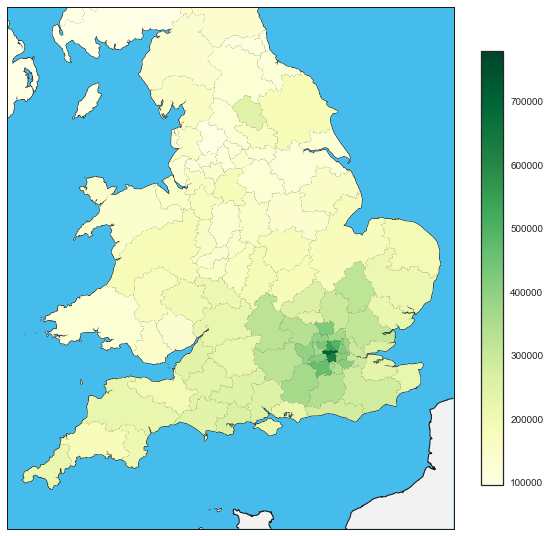

In [28]:
# -- Ploting the map 
fig, ax = plt.subplots(figsize=(10,20))

m = Basemap(resolution='f', # c, l, i, h, f or None
            projection='merc', 
            lat_0=54.5, lon_0=-4.36,
            llcrnrlon=-6., llcrnrlat= 49.5,urcrnrlon=2., urcrnrlat=55.2)
             
m.drawmapboundary(fill_color='#46bcec')
m.fillcontinents(color='#f2f2f2',lake_color='#46bcec')
m.drawcoastlines()

# Read the shapefiles
m.readshapefile('Areas', 'areas')

df_polygon = pd.DataFrame({
        'shapes': [Polygon(np.array(shape), True) for shape in m.areas],
        'area': [area['name'] for area in m.areas_info]
    })
df_polygon = df_polygon.merge(map_by_median_price, on='area', how='left')

cmap = plt.get_cmap('YlGn')   
pc = PatchCollection(df_polygon.shapes, zorder=2)
norm = Normalize(vmin=df_polygon['price'].min(), vmax=df_polygon['price'].max())

pc.set_facecolor(cmap(norm(df_polygon['price'].fillna(0))))
ax.add_collection(pc)

mapper = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)

mapper.set_array(df_polygon['price'])
plt.colorbar(mapper, shrink=0.4)

m

This map confirms what we said in the previous section, the most prized area markets in England and Wales form a halo around London. This area has even a name, they call it the "super suburbs".

## Conclusion

Without any knowledge about the UK real estate market, we found some interesting facts about :
- The impact of the tax increase (the "Buy-to-let stamp duty") in April 2016 who has an effect on the volume of transaction in march 2016.
- The fall of the median price of newly builts during the summer 2016, the Brexit seems to be the reason of that. 
- The volume of transaction in the end 2016 and in january 2017 seems essentially come from the Brexit, but the drop in YoY volumes seems to indicate that January 2016 was better than it should be, because the investors brought forward purchases to avoid new stamp duty rates.
- The "super suburbs" who has the higher median price of the UK. 